In [1]:
# numpy is the 'Numerical Python' package
import numpy as np

# Numpy's methods for pseudorandom number generation
import numpy.random as rnd

# scipy is the 'Scientific Python' package
# We'll use the stats package to get some p.d.f.s & c.d.f.s
from scipy import stats

import matplotlib.pyplot as plt 

%config InlineBackend.figure_format = 'retina'

## Part 1: Random number generation

1) Simulate $R=10^5$ $\mathsf{Pareto}(10,100)$ random variables, where our definition of $\mathsf{Pareto}(\alpha, \lambda)$ has the p.d.f. 


$$ f(x) = \begin{cases} 
    \frac{\alpha}{\lambda} \bigl[ 1 + \frac{x}{\lambda} \bigr]^{-(\alpha+1)} & \text{if } x > 0 \\
    0 & \text{otherwise.}
\end{cases} $$

Plot a histogram of these points against this p.d.f., like in the lectures.

In [2]:
rng = rnd.default_rng(1)
R = 10**5
α = 10.0
λ = 100.0
paretos = λ * rng.pareto(α, R)

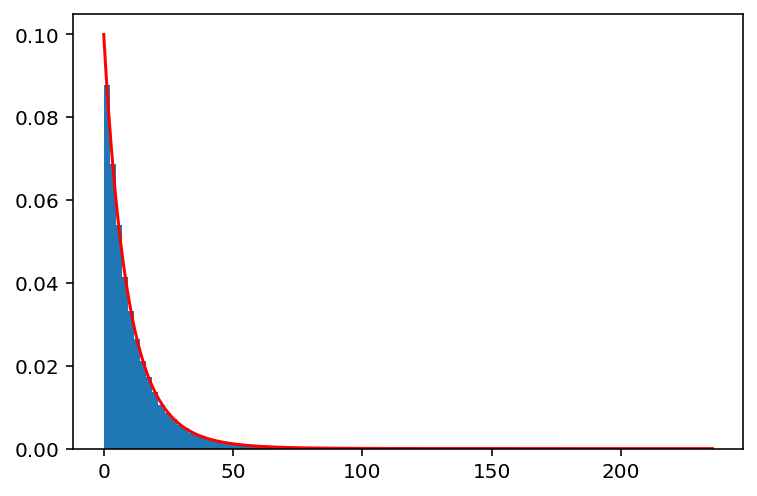

In [3]:
x = np.linspace(0, np.max(paretos), 500)
pdf = (α/λ)*(1+x/λ)**(-(α+1))

plt.plot(x, pdf, 'r')
plt.hist(paretos, bins=100, density=True);

2) Simulate $R = 10^5$ $\mathsf{LogNormal}(3,0.1)$ random variables, where our definition of $\mathsf{LogNormal}(\mu, \sigma^2)$ has the p.d.f. 


$$ f(x) = \begin{cases} 
    \frac{1}{x \sigma \sqrt{2 \pi} } \exp\bigl\{ -\frac{(\log(x) - \mu)^2 }{2 \sigma^2} \bigr\} & \text{if } x > 0 \\
    0 & \text{otherwise.}
\end{cases} $$

Plot the histogram of your samples against p.d.f. above.

In [4]:
R = 10**5
μ = 3
σ = np.sqrt(0.1)
lognormals = rng.lognormal(μ, σ, R)

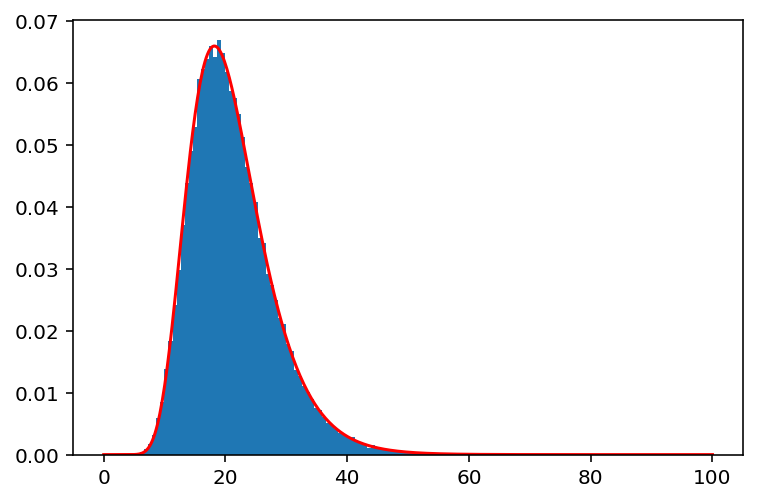

In [5]:
x = np.linspace(1e-5, 100, 500)
pdf = 1/(x*σ*np.sqrt(2*np.pi)) * np.exp(-(np.log(x)-μ)**2 / (2*σ**2))

plt.plot(x, pdf, 'r')
plt.hist(lognormals, bins=100, density=True);

3) Find $\overline{\mu}$, $\overline{\sigma}$ such that $X \sim \mathsf{LogNormal}(\overline{\mu}, \overline{\sigma}^2)$ has $\mathbb{E}[X] = m$ and $\mathbb{V}[X] = v$.

Simulate $R = 10^5$ lognormal random variables from the $\mathsf{LogNormal}(\overline{\mu}, \overline{\sigma}^2)$ where $m = 150$ and $v = 500$.

Plot a histogram of the simulated points, and overlay a vertical line at $x = m = 150$ to check that the simulated points are near the desired mean. 

__For style points__: Find $\overline{\mu}$, $\overline{\sigma}$ using the `solve` function from the `sympy` 'symbolic python' package.

In [6]:
import sympy as sym

μ, σ, m, v = sym.symbols('μ σ m v')

mean = sym.exp(μ + σ**2 / 2)
var = (sym.exp(σ**2) - 1) * sym.exp(2*μ + σ**2)

sym.solve((m - mean, v - var), (μ, σ))

[(log(m) - log(1 + v/m**2)/2, -sqrt(log(1 + v/m**2))),
 (log(m) - log(1 + v/m**2)/2, sqrt(log(1 + v/m**2)))]

In [7]:
m = 150
v = 500

μBar = np.log(m) - np.log(1 + v/m**2)/2
σBar = np.sqrt(np.log(1 + v/m**2))
R = 10**5

In [8]:
lognormals = rng.lognormal(μBar, σBar, R)

In [9]:
print("Sample mean:", lognormals.mean())
print("Theoretical mean:", m)
assert np.isclose(lognormals.mean(), m, rtol=0.01)

Sample mean: 149.92195398260404
Theoretical mean: 150


In [10]:
print("Sample var:", lognormals.var())
print("Theoretical var:", v)
assert np.isclose(lognormals.var(), v, rtol=0.01)

Sample var: 497.6989282181114
Theoretical var: 500


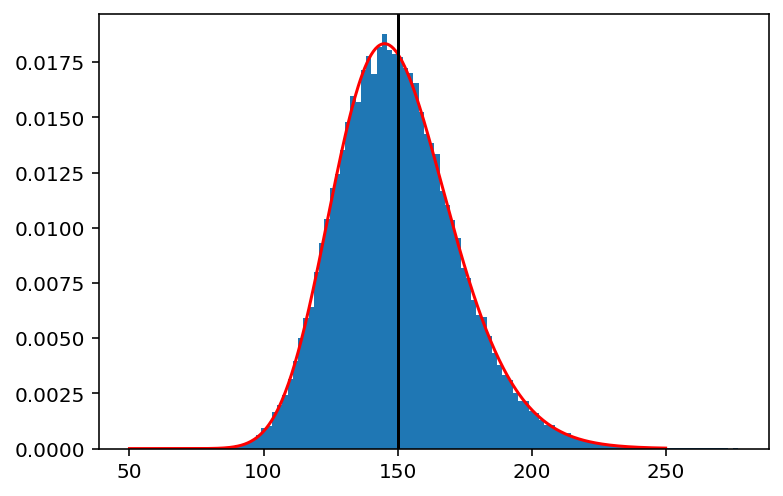

In [11]:
x = np.linspace(50, 250, 500)
pdf = 1/(x*σBar*np.sqrt(2*np.pi)) * np.exp(-(np.log(x)-μBar)**2 / (2*σBar**2))

plt.plot(x, pdf, 'r')
plt.hist(lognormals, bins=100, density=True);
plt.gca().axvline(m, c='black');

## Part 2: Crude Monte Carlo

1) We model an insurer's risk reserve process $R_t$ as

$$ R(t) = u + p t - \sum_{i=1}^{N_t} U_i $$

where $u \ge 0$, $p > 0$, $N_t$ is a Poisson process with intensity $\lambda$ and $U_i \overset{\mathrm{i.i.d.}}{\sim} \mathsf{Gamma}(r, m)$. 

The only possible times when the insurer's reserve can become negative is at the times $T_1, T_2, \dots$ when the claims arrive. Define

$$ R_i = R(T_i) , \quad i = 1, 2, \dots,$$

which is reserve calculated at the time when the $i$-th claim arrives (and including this claim). 

Estimate 

$$\mathbb{P}(\text{Ruin before } n \text{-th arrival}) = \mathbb{P}(\min\{R_1,\dots,R_n\} < 0)$$

using crude Monte Carlo.

N.B. With $T_0 \equiv 0$, then we have $T_i - T_{i-1} \overset{\mathrm{i.i.d.}}{\sim} \mathsf{Exponential}(\lambda)$ for $i=1,2,\dots$

Constants:

In [12]:
u = 1
p = 0.3
λ = 0.5
n = 50
r = 1
m = 0.5

R = 10**6

In [13]:
%%time 

T = np.zeros(R)
claims = np.zeros(R)
R_n = np.zeros(R)

alive = np.full(R, True)
overshoot = np.full(R, np.nan)
ruinTime = np.full(R, np.nan)

for i in range(1, n+1):
    T += rng.exponential(1/λ, size=R)
    claims += rng.gamma(r, m, size=R)    
    R_n = u + p * T - claims
    
    justRuined = alive & (R_n < 0)
    alive[justRuined] = False
    overshoot[justRuined] = R_n[justRuined]
    ruinTime[justRuined] = i 

ℓHat = 1 - alive.mean()
σHat = alive.std()
widthCI = 1.96 * σHat / np.sqrt(R)
print(f"CMC estimate:\t {ℓHat} (+/- {widthCI})")
print(f"CMC low bound:\t {np.maximum(ℓHat-widthCI, 0)}")
print(f"CMC upp bound:\t {ℓHat+widthCI}")

CMC estimate:	 0.554385 (+/- 0.0009741856041077799)
CMC low bound:	 0.5534108143958922
CMC upp bound:	 0.5553591856041078
Wall time: 3.42 s


Conditioned on a bankruptcy event, what is the expected value of the reserve process (it will be negative)?

In [14]:
ests = overshoot[~alive]
ℓHat = ests.mean()
σHat = ests.std()
widthCI = 1.96 * σHat / np.sqrt(R)
print(f"CMC estimate:\t {ℓHat} (+/- {widthCI})")
print(f"CMC low bound:\t {ℓHat-widthCI}")
print(f"CMC upp bound:\t {ℓHat+widthCI}")

CMC estimate:	 -0.499587266700193 (+/- 0.0009820346402831667)
CMC low bound:	 -0.5005693013404762
CMC upp bound:	 -0.4986052320599098


Conditioned on a bankruptcy event, when does it occur? Plot a histogram of <!-- the distribution of the bankruptcy time ($\in \mathbb{R}$), and another histogram of -->
the claim number which causes bankruptcy ($\in \mathbb{N}$). 

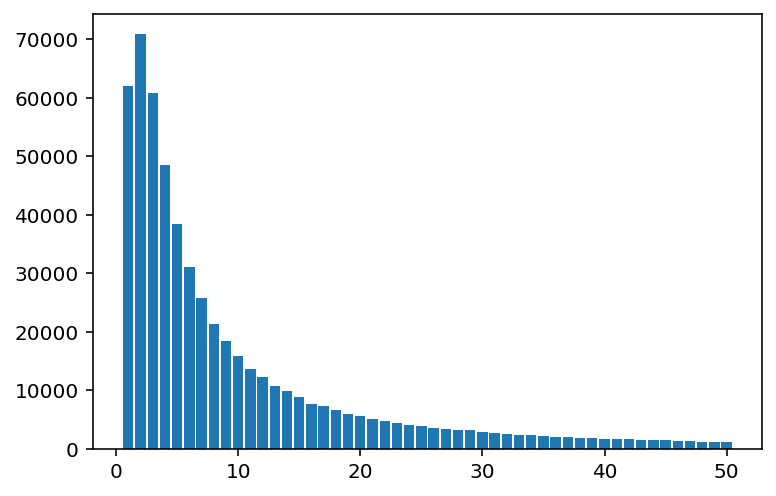

In [15]:
# This is the easiest solution
#plt.hist(ruinTime[~alive], n);

# But this is a better looking version
plt.hist(ruinTime[~alive], np.arange(51)+0.5, rwidth=0.85);

## Part 3: Importance sampling

Consider estimating $\mathbb{P}(\max\{X_1, X_2\} > 5)$ where $X_i \overset{\mathrm{i.i.d.}}{\sim} \mathsf{Exponential}(1)$. 

Use importance sampling, where each $X_i \overset{\mathrm{i.i.d.}}{\sim} \mathsf{Exponential}(\lambda)$ for some $\lambda \in (0, 1)$.

Do this where $\lambda$ takes values in a grid of points between 0 and 1. Plot the IS estimates and the IS variances, like in the lecture slides (complete with horizontal line for the true value, and the vertical line at the minimal variance $\lambda$).

In [16]:
λs = np.linspace(0.01, 1, 25)
R = 10**6

ellHats = np.zeros_like(λs)
sigmaHats = np.zeros_like(λs)

rng = rnd.default_rng(1)

for i, λ in enumerate(λs):
    
    # Simulating the index value at T
    exps = rng.exponential(1/λ, size=(R, 2))
    maxs = np.max(exps, axis=1)
 
    # Calculate likelihood ratios
    lrNumer = stats.expon.pdf(exps, scale=1)
    lrDenom = stats.expon.pdf(exps, scale=1/λ)
    lrs = np.prod(lrNumer / lrDenom, axis=1)

    # Calculating the MC estimate and CIs
    ests = lrs * (maxs > 5)
    ellHats[i] = ests.mean()
    sigmaHats[i] = ests.std()

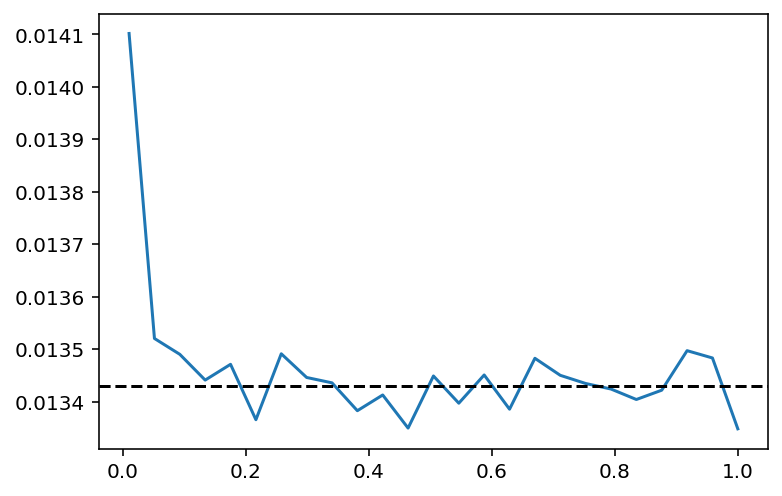

In [17]:
plt.plot(λs, ellHats)
plt.axhline(1 - (1-np.exp(-5))**2, ls="dashed", c="k");

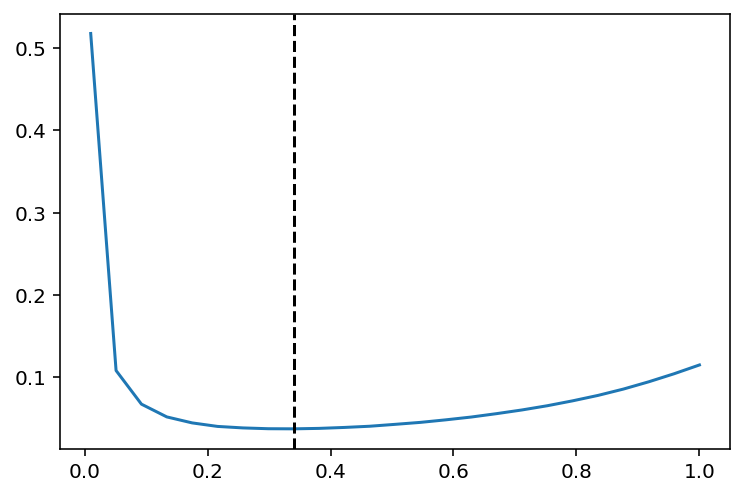

In [18]:
# This is actually plotting the standard deviations instead of variances.
plt.plot(λs, sigmaHats)
plt.axvline(λs[np.argmin(sigmaHats)], ls="dashed", c="k");

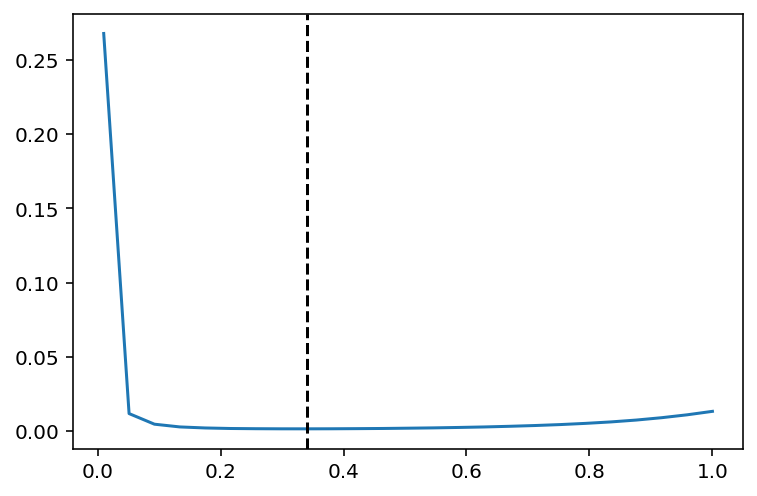

In [19]:
# This is the actual variance plot.
plt.plot(λs, sigmaHats**2)
plt.axvline(λs[np.argmin(sigmaHats)], ls="dashed", c="k");

Redo the financial example from the lecture (option pricing with the sum of correlated lognormals) but apply any importance sampling you like. Show the price estimate with a 95% confidence interval, but make sure your choice of importance distribution gives you a smaller confidence interval then crude Monte Carlo.

Here is a crude Monte Carlo estimate. Some of the problem specification constants may be changed (compare to the lecture), use these values. 

In [20]:
# Problem constants
n = 2
r = 0.05
T = 1
K = 4
ρ = -0.5
σ2 = 1/10
R = 10**6

# Mean vector and covariance matrix
μ = np.arange(1, n+1) / 10
Σ = σ2 * ( (1-ρ) * np.eye(n) + ρ * np.ones(n) )

# Simulating the index value at T
rng = rnd.default_rng(1)
normals = rng.multivariate_normal(μ, Σ, size=R)
Xs = np.exp(normals)
Ss = Xs.sum(axis=1)

# Calculating the MC estimate and CIs
ests = np.exp(-r*T) * np.maximum(Ss - K, 0)
ellHatCMC = ests.mean()
sigmaHatCMC = ests.std()
widthCICMC = 1.96 * sigmaHatCMC / np.sqrt(R)

print(f"CMC option price: {ellHatCMC} (+- {widthCICMC}))")
print(f"Fraction of simulated options which payed out: {np.mean(Ss - K > 0)}")

CMC option price: 0.0004718514314568297 (+- 2.9660800832771642e-05))
Fraction of simulated options which payed out: 0.001936


N.B. To calculate pdf of this original distribution at the points in some array `x` use `stats.multivariate_normal.pdf(x, μ, Σ)`

In [22]:
σ2Dash = 10 * σ2

ΣDash = σ2Dash * ( (1-ρ) * np.eye(n) + ρ * np.ones(n) )

# Simulating the index value at T
rng = rnd.default_rng(1)
normals = rng.multivariate_normal(μ, ΣDash, size=R)
Xs = np.exp(normals)
Ss = Xs.sum(axis=1)

# Calculate likelihood ratios
lrNumer = stats.multivariate_normal.pdf(normals, μ, Σ)
lrDenom = stats.multivariate_normal.pdf(normals, μ, ΣDash)
lrs = lrNumer / lrDenom

# Calculating the MC estimate and CIs
ests = lrs * np.exp(-r*T) * np.maximum(Ss - K, 0)
ellHat = ests.mean()
sigmaHat = ests.std()
widthCI = 1.96 * sigmaHat / np.sqrt(R)

print(f"IS option price: {ellHat} (+- {widthCI}))")
print(f"Fraction of simulated options which payed out: {np.mean(Ss - K > 0)}")

IS option price: 0.00046363739368650243 (+- 3.333208983109775e-06))
Fraction of simulated options which payed out: 0.321168
